<a href="https://colab.research.google.com/github/daphnecor/NeuroAnalysis/blob/main/NA3_ReplayDecoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neuro Analysis 3: Replay and decoding

```
Student: Daphne Cornelisse 1066862
```

In [41]:
#@title Commands to run matlab code in colab notebook 
!pip install oct2py
!apt-get install octave

%reload_ext oct2py.ipython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (4.2.2-1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## 1 Decoding on a linear track

**Main ideas**
- If certain neurons are consistently active when a given stimulus is presented, we can predict the activity at a later timepoint.
- In the context of the Hippocampus and place cells, the number of different positions $x$ (1D case) or $\mathbf{x} = [x, y]$ (2D case)
 an animal can occupy in an environment are the external stimuli. 
  - These external stimuli are reflected in the activity of the cells.
- Our goal is to reconstruct the current position of the animal given the recorded activity of a set of place cells.


### 1.1 Place field properties

- Generate a place field map
- Spike trains are simulated as inhomogeneous Poisson processes, where the rate $\lambda$ is
determined by the current animal position $x$. 
- An inhomogeneous Poisson process is a random process where the instantaneous probability to have an event at time  (more precisely, the probability of having an event between times $t$ and $t+dt$  is given by: 

\begin{align}
P( \text{event in}[t, t+dt]=\lambda(t)dt
\end{align}

In [59]:
%%octave

track_length = 200; % the length of our linear track (eg in cm)
average_firing_rate = 5; % the peak firing rate, averaged across the population 
n_cells = 20; % how many cells we are recording
pf_centers = rand(n_cells,1) * track_length; % the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = gamrnd(10,1, n_cells,1); % the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = exprnd(average_firing_rate,n_cells,1); % the peak firing rate for each cell, drawn from an exponential distribution

### 1.2 Build the place field representation 

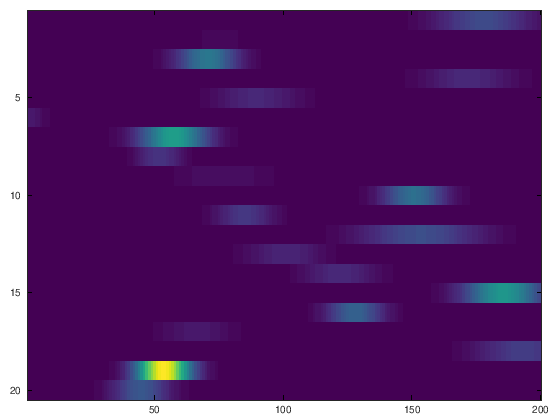

In [60]:
%%octave

bins=1:track_length;
true_firing_rate=zeros(n_cells,track_length);
%Place Fields have a Gaussian shape
for i=1:n_cells
    true_firing_rate(i,:)=pf_rate(i).*exp(-(bins-pf_centers(i)).^2/(2*pf_size(i)^2));
end

imagesc(true_firing_rate)

### 1.3 Generate random trajectory on the linear track

Let's simulate the trajectory of the virtual mouse on the track. As we are only interested in the periods during which the animal is moving, we will omit the pauses at the two ends of the track. The trajectory will therefore consits of laps directly alternating between the two running directions. 

In [61]:
%%octave

n_runs = 20; 
av_running_speed = 10;% the average running speed (in cm/s)
fps = 10; % the number of video frames per second 
running_speed_a = chi2rnd(av_running_speed, n_runs,1); % running speed in the two directions
running_speed_b = chi2rnd(av_running_speed, n_runs,1); 

x = [];
for i=1:n_runs
  run_length = numel(bins) * fps / running_speed_a(i);
  run1 = linspace(0.1, numel(bins), round(run_length));
  run_length = numel(bins) * fps / running_speed_b(i);
  run2 = linspace(numel(bins), 0.1, round(run_length));
  x=cat(1,x,run1(:),run2(:));
end

t=(1:numel(x))./fps;  

### 1.4 Generate spikes for cells
Combining the rate maps and the trajectory generated above we can now simulate the spiking activity of our neural population.

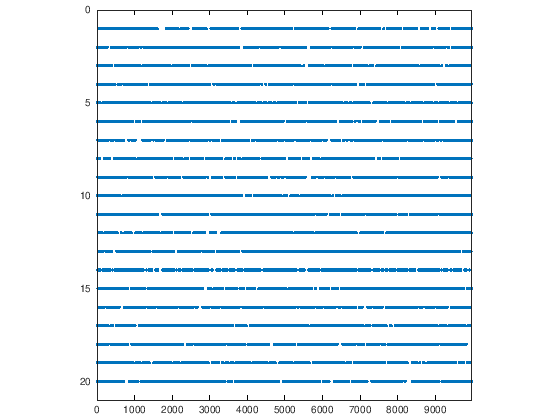

In [62]:
%%octave

sampling_rate = 10; %This corresponds to time windows of 100ms, a natural choice in the case of hippocampal data. 
t_sampling = (1:numel(t))./sampling_rate;
x_sampling = ceil(interp1(t, x,t_sampling,'linear','extrap'));
noise_firing_rate = 1; % the baseline noise firing rate

spikes = zeros(n_cells,numel(t_sampling));

for i=1:n_cells
    inst_rate = true_firing_rate(i,x_sampling) + randn(1,numel(x_sampling))*noise_firing_rate;
    inst_rate(inst_rate<0) = 0;
    spikes_loc = poissrnd(inst_rate/sampling_rate);
    spikes(i,:)=spikes_loc;
    
end

spy(spikes)
axis square

### 1.5 Reconstruct place-related activity from sampled activity

We are now ready to proceed with the first step towards decoding of position. We will start by looking at how different locations are encoded by the neurons. To do that we will collect all the activity emitted by the neurons in a specific location and average it to obtain a Population Vector (PV) associated to that position, or equivalently we will say that the firing rate combination of this PV represent that location. Since we will do this for every location in the environment we will end up having the PVs associated to every portion of the environment. 

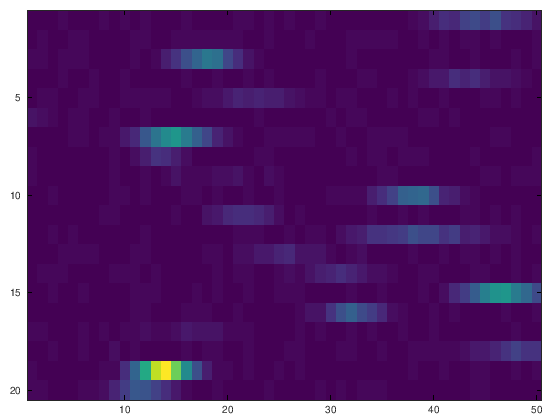

In [63]:
%%octave

% To estimate the PVs we will use bins of some cms in length 
bin_size = 4; % Size in cm of bins to use for encoding
n_bins = track_length/bin_size;

estim_firing_rate=zeros(n_cells,n_bins);

% Rescale the trajectory to the new binning 
x_sampling_binned = ceil(x_sampling/(bin_size));

% Calculate the PV for every bin
for j=1:n_bins
    
    X_bin=find(x_sampling_binned==j);
    estim_firing_rate(:,j)=sum(spikes(:,X_bin),2)*sampling_rate./(numel(X_bin));
end

imagesc(estim_firing_rate)

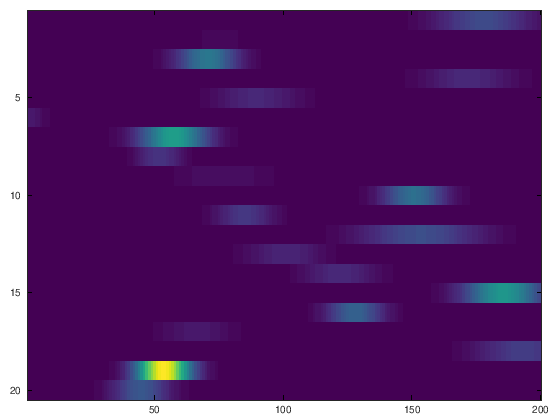

In [64]:
%%octave

imagesc(true_firing_rate)

Since the spikes we are using to estimate the track representation are a finite sample of the '"ground-truth" maps, and we added random noise in the process, the reconstructed maps will not be identical to the original ones. 

Actually, they can be quite different, especially in real experiments where the amount of data is limited, the behaviour of the animal is not completely controlled, neural activity is subject to high level of noise, and obviously we don't have access to the "ground-truth". 

---

> **Question 1.** In the context of the simulated data, one can look at the effects of data amount and the level of noise on the accuracy of the PV estimation. Build a table expressing the relationship between noise level, amount of recorded neurons and the difference between real and constructed maps.

---

We select a subset of the `true_firing_rate` array to make sure the shapes are the same.

- `noise_firing_rate` controls the amount of noise in the system. We increase the noise by allocating a larger number to this variable.
- `n_cells` is the number of neurons we record from. 




`n_cells`        | `noise_firing_rate`   | `max`(Euclidean distance)
--------------   |  ------------------   | -----------------
   20            |   1                   | 6.6082
   50            |   1                   | 7.3
   100           |   1                   | 9.8
   20            |   5                   | 11.927
   20            |   10                  | 22.617


From the table we can derive the following: 
- The more neurons from which we record, the larger the differences between the true firing rates and the estimates ones.
- The higher the noise firing rate, the larger the differences between the true firing rates and the estimates ones.


In [65]:
%%octave

disp(size(true_firing_rate(:, 1:bin_size:end)))

disp(size(estim_firing_rate))

   20   50

   20   50

In [66]:
%%octave

% Take the maximum of the Euclidean distance to quantify the difference
max(sqrt(sum((true_firing_rate(:, 1:bin_size:end) - estim_firing_rate).^2)))

ans =  4.1254

## 2 Bayesian decoding

Now that we have estimated the PVs associated to the track environment, we can move on to decoding. 

A very common approach is given by the so called Bayesian Decoding. Let $P(s)$ denote the probability of presentation of stimulus $s$ (belonging to a set $S$) and $P(r|s)$ denote the conditional probability of obtaining a population response $r$ (out of a response set $R$) when stimulus $s$ is presented. Using Bayes'theorem, we obtain:
\begin{align}
P(s|r)=\frac{P(r|s) P(s)}{P(r)}
\end{align}

This equation gives the posterior probability that, given a response $r$, stimulus s was presented. Bayesian decoding calculates from this posterior probability distribution a single prediction of the most likely stimulus 
\begin{align}
s^* = \text{arg max}_s P(s|r)
\end{align}

In our case the set of stimuli $S$ are the different locations in the environment. Since we are looking for the maximum, we can ignore the denominator term $P(r)$, as it is common to all positions s (luckily for us, as it is generally very difficult to estimate experimentally). Moreover we will assume that every position s is equiprobable, so we can also ignore the term $P(s)$. Assuming that our neurons are independant (a banality in our simulations, but not necessarily true when considering real neurons), we are left with: 
\begin{align}
s^*= \text{arg max}_s \left( \prod_iP(r_i|s) \right)
\end{align}

Here is the code to perform bayesian decoding: 

### 2.1 Bayesian decoding with single placefields

In [67]:
%%octave

% First, we generate a new set of runs and spikes from the same cells to use for the decoding, so that we avoid overfitting problems by using the same data for training and testing. 
n_runs_deco = 10;

av_running_speed = 20;% the average running speed (in cm/s)
fps = 10; % the number of "video frames" per second 
running_speed_a = chi2rnd(av_running_speed, n_runs_deco,1); % running speed in the two directions
running_speed_b = chi2rnd(av_running_speed, n_runs_deco,1); 

x = [];
for i=1:n_runs_deco
    run_length = numel(bins) * fps / running_speed_a(i);
    run1 = linspace(0.1, numel(bins), round(run_length));
    run_length = numel(bins) * fps / running_speed_b(i);
    run2 = linspace(numel(bins), 0.1, round(run_length));
    x=cat(1,x,run1(:),run2(:));
end

t=(1:numel(x))./fps;  

sampling_rate = 10; %This corresponds to time windows of 100ms, a natural choice in the case of hippocampal data. 
t_sampling = (1:numel(t))./sampling_rate;
x_sampling = ceil(interp1(t, x,t_sampling,'linear','extrap'))';
noise_firing_rate = 1; % the baseline noise firing rate

spikes = zeros(n_cells,numel(t_sampling));

for i=1:n_cells
    inst_rate = true_firing_rate(i,x_sampling) + randn(1,numel(x_sampling))*noise_firing_rate;
    inst_rate(inst_rate < 0) = 0;
    spikes_loc = poissrnd(inst_rate/sampling_rate);
    spikes(i,:)=spikes_loc;
end

In [68]:
%%octave

% Here we perform the decoding using the data just generated
x_decoded=zeros(size(spikes, 2), 1);

for t_bin=1:size(spikes,2)
    
    if(sum(spikes(:,t_bin),1) > 0) % Check if the time window contains spikes
        Post_p=NaN(size(estim_firing_rate,2), 1);
        
        for i=1:size(estim_firing_rate, 2)
            % Note that we work with log so that we can sum probabilities
            % instead of multiplying them 
            Post_p(i)=sum(log(poisspdf(spikes(:,t_bin), estim_firing_rate(:,i)/sampling_rate)));
        end
        
        x_decoded(t_bin) = find(Post_p==max(Post_p), 1, 'first');

    else
        x_decoded(t_bin) = NaN;   
    end
end

---

> **Question 2.** What is the reason for computing the log-probability instead of a probability?

---

I can see three main reasons:
- Taking the log simplifies computations. (e.g. $\log(ab) = \log(a) + \log(b)$)
- Probabilities are often values very close to zero. Log probabilities make it easier to compare values close to zero.
- In statistical physics log probabilities have a physical meaning (think for example about entropy).

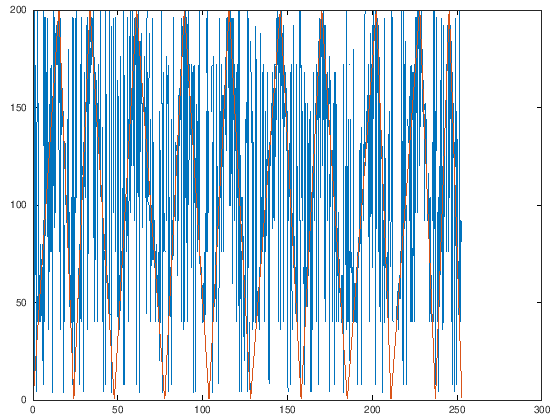

In [69]:
%%octave 

%Plot the real trajectory agains the reconstructed one
plot(t_sampling, x_decoded*bin_size, t_sampling, x_sampling)

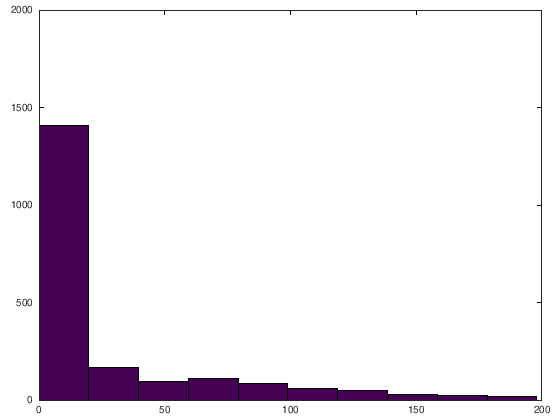

In [70]:
%%octave

%Distribution of errors
hist(sqrt(((x_sampling - x_decoded*bin_size).^2)))

In [71]:
%%octave

%To reduce the effects of the few large errors, the median error, rather
%than the mean error, is a commonly used measure of decoding precision

median(sqrt(((x_sampling-x_decoded*bin_size).^2)))

ans = NaN

---

> **Question 3.** how much data is required to reduce the median error? Use smaller fractions of data to estimate PVs and measure how this affects the decoding error. Use 30 cells, between 1 and 20 runs for the estimation of the place fields and use 2 levels for noise (ex. 1 and 5). 

---

Reducing the PV size reduces the decoding error. This makes sense as the smaller the size, the more accurate we can estimate the place fields.


---

> **Question 4.** How does the reconstruction error scales with the number of available place cells? Having many cells representing an environment allows for more information to be found in the same time window and reduces the effect of random noise. But how many place cells would be requied on average to accurately represent position on a linear track? Quantify the average decoding error obtainable with different population sizes and find for what value it reaches its asymptot. You can use 5 runs for the encoding and a noise level of 5. 

---

According to my results, around 100-200 neurons are required to accurately decode represent position.

---

> **Question 5.** Bayesian decoding is not the only available option (Abbott). Another possibility is to directly compare the activity present in a given time window with all PVs and find which one is the more "similar" (then the associated position would be the decoded one). As a definition of similarity one can use euclidean distance, correlation, cosine distance. Compare the performance of different decoding approaches. For example use Bayesian and correlation-based decoding. Run the same analysis of Question 4 (different cell sample size) with the two methods. 

---

Different methods give different results, here I used the absolute distance and the euclidean (pdist doesn't work in octave apparently..)

In [86]:
%%octave

max(sqrt(sum(x_sampling-x_decoded*bin_size.^2)))

ans = NaN

In [87]:
%%octave

max(abs(x_sampling-x_decoded*bin_size))

ans =  198

### 2.2 Multiple place field case

Multiple place field case
The case presented above is the most ideal one can think of for performing decoding of position: a simple 1D environment with place cells being active in only one location.
We now want to see what are the effects on decoding of more heterogeneous conditions. We start with allowing each place cell to develop, with a certain probability, a second place field in a new location. We can generate such map with the following code:

In [56]:
%%octave

track_length = 200; % the length of our linear track (eg in centimeter)
average_firing_rate = 5; % the peak firing rate, averaged across the population 
n_cells = 20; % how many cells we are recording
pf_centers = rand(n_cells,2) * track_length; % the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = gamrnd(10,1, n_cells,2); % the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = exprnd(average_firing_rate,n_cells,2); % the peak firing rate for each cell, drawn from an exponential distribution

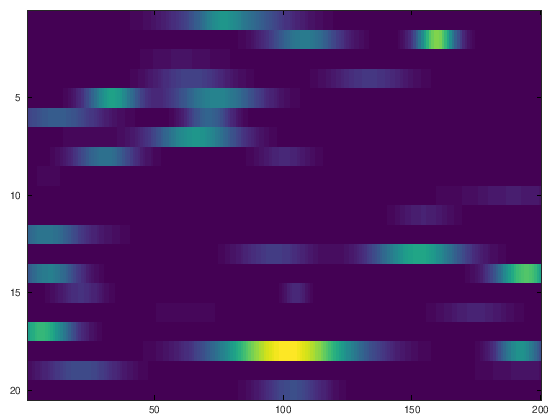

In [57]:
%%octave

prob_2field=0.9; %This is the probability that a cell will have 2 fields instead of one

bins=1:track_length;
true_firing_rate=zeros(n_cells,track_length);

for i=1:n_cells
    n_fields=1+(rand(1)<prob_2field);
    for j=1:n_fields
    true_firing_rate(i,:)=true_firing_rate(i,:)+pf_rate(i,j).*exp(-(bins-pf_centers(i,j)).^2/(2*pf_size(i,j)^2));
    end
end

imagesc(true_firing_rate)